<a href="https://colab.research.google.com/github/PradyumnaCharate/Mask_Detection_System/blob/main/mask_detection_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('mask-detection-system')
jovian.set_colab_id('1RujwleLYVMOJzkcDGQ0OjYOpfNhDRXJV')

     |████████████████████████████████| 68 kB 4.9 MB/s 


# Mask-Detection-System

Use the "Run" button to execute the code.

Importing necessary libraries

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# **Masked-Detection-System**


In these Covid pandemic,masks have became compulsary to all.But many people avoid masks,that is why coronavirus spreads easily and fastly.
This dataset is used for Face Mask Detection Classification with images. The dataset consists of almost 12K images.
At the end we will be able to tell if Person has mask or not.**(It is image classification problem )**

Let's begin by downloading the dataset and creating PyTorch datasets to load the data.

There are variety of images and faces.Faces with different angle,Different type of masks.Also they have Different background .So I think this dataset is perfect for Deep Learning 

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od
dataset_url = "https://www.kaggle.com/pradyumnacharate/face-mask-detection?select=Face_Mask_Detection"
od.download(dataset_url)



100%|██████████| 35.9M/35.9M [00:00<00:00, 56.3MB/s]


In [ ]:
data_dir = '/content/face-mask-detection/Face_Mask_Detection'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/Train")
print(classes)

['Validation', 'Test', 'Train']
['Without-Mask', 'With-Mask']


I am just creating datasets and dataloaders to calculate mean and standard deviation of data for purpose of normalisation of images

In [ ]:
train_dataset=ImageFolder(data_dir+"/Train",tt.ToTensor())
validation_dataset=ImageFolder(data_dir+"/Validation",tt.ToTensor())
test_dataset=ImageFolder(data_dir+"/Test",tt.ToTensor())


In [ ]:
batch_size=128

In [ ]:
# PyTorch data loaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(validation_dataset, batch_size, num_workers=2, pin_memory=True)

In [ ]:
test_dl = DataLoader(test_dataset, batch_size, num_workers=2, pin_memory=True)

In [ ]:
def get_mean_std(dl):#Get mean and standard deviation of images channels
  channel_sum,channel_squarred_sum,num_batches=0, 0, 0
  for data,_ in dl:
    channel_sum += torch.mean(data,dim=[0,2,3])
    channel_squarred_sum += torch.mean(data**2,dim=[0,2,3])
    num_batches += 1
  
  mean=channel_sum/num_batches
  std=(channel_squarred_sum/num_batches - mean**2)**0.5
  return list(mean.tolist()),list(std.tolist())

In [ ]:
train_stats=get_mean_std(train_dl)#Get mean and standard deviation of train dataset

In [ ]:
valid_stats=get_mean_std(valid_dl)#Get mean and standard deviation of validation dataset

In [ ]:
train_stats

([0.5677967071533203, 0.46416154503822327, 0.4155223071575165],
 [0.2762463390827179, 0.25274592638015747, 0.25459614396095276])

In [ ]:
test_stats=get_mean_std(test_dl)#Get mean and standard deviation of test dataset

We will do normalisation so that all pixels ranges between -1 and 1.Also we will do some editing on images.so that model will see different images each time and it will not overfit on training data.This is called Data Augmentation

In [ ]:
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         #tt.RandomRotate,
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*train_stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(),tt.Normalize(*valid_stats)])
test_tfms=tt.Compose([tt.ToTensor(),tt.Normalize(*test_stats)])

Now we will create dataset and dataloaders again to actually train the **dataset**

In [ ]:
train_dataset=ImageFolder(data_dir+"/Train",train_tfms)
validation_dataset=ImageFolder(data_dir+"/Validation",valid_tfms)
test_dataset=ImageFolder(data_dir+"/Test",test_tfms)

In [ ]:
# PyTorch data loaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(validation_dataset, batch_size, num_workers=2, pin_memory=True)

In [ ]:
test_dl=DataLoader(test_dataset,batch_size,num_workers=2,pin_memory=True)

In [ ]:
def denormalize(images, means, stds):
  means = torch.tensor(means).reshape(1, 3, 1, 1)
  stds = torch.tensor(stds).reshape(1, 3, 1, 1)
  return images * stds + means 

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *train_stats)#We have normalised images so to properly see images we should denormalise them
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        print(images.shape)
        break

torch.Size([128, 3, 32, 32])


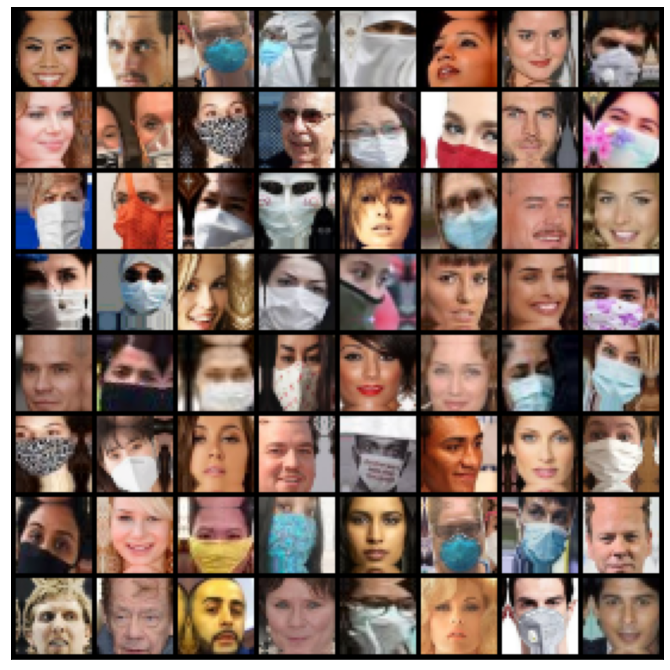

In [ ]:
show_batch(train_dl)

It seems that all images have dimensions 3 into 32 into 32.
So we have 3 input channels

# **Using a GPU**

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device#If we get cuda gpu is available

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)#Moving dataloaders to device
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
test_dl=DeviceDataLoader(test_dl,device)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

# **Model with Residual Blocks and CNN Networks architecture**

In [ ]:
def conv_block(in_channels, out_channels, pool=False):#To avoid repeating of code we write convolution block function to use in our resnet architecture
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

Here we have two classes.

1.With Mask images 

2.Without Mask images 

So we will create a model with 2 final output channels or feature maps

In between we will pass 3 channel image tensors through multiple convolutional layers and max pool and RElu activation function layer.(As each image in dataset is 3 channel image *32*32)

We also have batch normalisation layer in each conv block

In [ ]:
model = to_device(ResNet9(3, 2), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

# **Training A Model**

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[{'val_acc': 0.5535714030265808, 'val_loss': 0.6945745944976807}]

Initially we have 55% accuracy.That may see like too much for randomly initiated weights.But we have only 2 classes so dumb model can also have accuracy uupto 50%.So It is acceptable.

Lets train further

In [ ]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00276, train_loss: 0.1783, val_loss: 0.1444, val_acc: 0.9554
Epoch [1], last_lr: 0.00758, train_loss: 0.1387, val_loss: 0.4982, val_acc: 0.9040
Epoch [2], last_lr: 0.01000, train_loss: 0.1292, val_loss: 0.4936, val_acc: 0.8694
Epoch [3], last_lr: 0.00950, train_loss: 0.0955, val_loss: 0.1388, val_acc: 0.9609
Epoch [4], last_lr: 0.00812, train_loss: 0.0475, val_loss: 0.0411, val_acc: 0.9833
Epoch [5], last_lr: 0.00611, train_loss: 0.0341, val_loss: 0.0506, val_acc: 0.9810
Epoch [6], last_lr: 0.00389, train_loss: 0.0336, val_loss: 0.0349, val_acc: 0.9900
Epoch [7], last_lr: 0.00188, train_loss: 0.0185, val_loss: 0.0134, val_acc: 0.9922
Epoch [8], last_lr: 0.00050, train_loss: 0.0131, val_loss: 0.0142, val_acc: 0.9911
Epoch [9], last_lr: 0.00000, train_loss: 0.0086, val_loss: 0.0100, val_acc: 0.9955
CPU times: user 13.3 s, sys: 3.19 s, total: 16.5 s
Wall time: 1min


So Because We only have 2 classes ,It has 99 % accuracy. and that is great.We should predict on single images and also we should predict on entire test dataset. and see test dataset accuracy

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

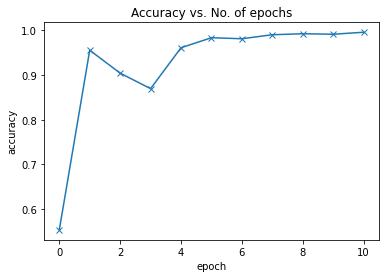

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

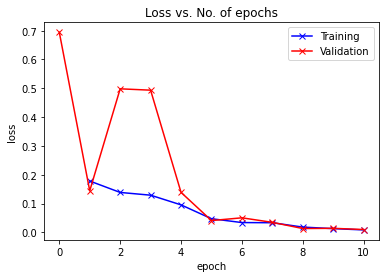

In [ ]:
plot_losses(history)

In between model is overfitted on training data and at that time validation accuracy is also low.But after that it is not overfitted on training data.It runs parallel with it

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

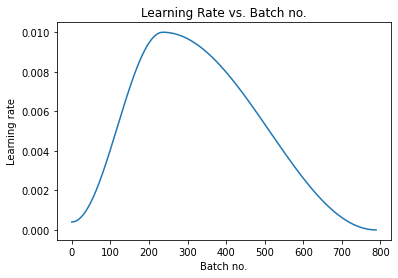

In [ ]:
plot_lrs(history)

This is one cycle learning rate policy.SO this is expected.

# **Testing on Indivisual Images**

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_dataset.classes[preds[0].item()]

Label: With-Mask , Predicted: With-Mask


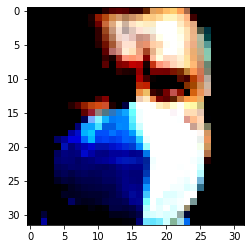

In [ ]:
img, label = validation_dataset[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, model))

# **This feels so much exciting.Our model is predicting correctly.Lets do this for few more images**

Label: With-Mask , Predicted: With-Mask


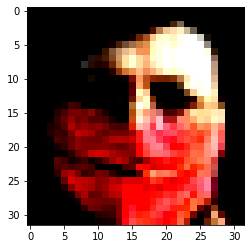

In [ ]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, model))

And as expected ,,

For test dataset also Our model is predicting right

Label: Without-Mask , Predicted: Without-Mask


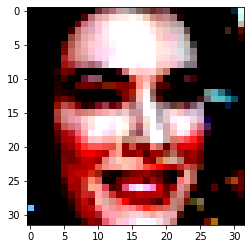

In [ ]:
img, label = test_dataset[600]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, model))

This is one without mask.And people without mask will be automatically detected and punished for breaking the rule as in India mask is compulsary

# **Testing on Test Dataset**

In [ ]:
history1 = [evaluate(model,test_dl)]
history1

[{'val_acc': 0.998046875, 'val_loss': 0.00820653885602951}]

Thats Fascinating,We have Perfect test dataset accuracy

# **Saving the model and logging hyperparameters**

In [ ]:
torch.save(model.state_dict(), 'Mask-detection-system-resnet9.pth')

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch='resnet9', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [ ]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history1[-1]['val_loss'],
            )

[jovian] Metrics logged.


In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/pradyumnacharate1/mask-detection-system


'https://jovian.ai/pradyumnacharate1/mask-detection-system'

In [ ]:
jovian.commit(project="mask-detection-system", environment=None, outputs=['Mask-detection-system-resnet9.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/pradyumnacharate1/mask-detection-system


'https://jovian.ai/pradyumnacharate1/mask-detection-system'

# **Summary**

We trained state-of-the-art deep learning model from scratch.

# We succesfully builded Mask-Detection System with images.In India Corona Virus is spreading largely.And people without masks is big reason of that.
# we should spread awareness into people.
# With the help of this system,We can detect people without masks and accordingly punish them.This will help us to stop the spread of coronavirus and people will use masks all the time. 
Here's a summary of the different techniques used in this project to improve our model performance and reduce the training time:

Data normalization: We normalized the image tensors by subtracting the mean and dividing by the standard deviation of pixels across each channel. Normalizing the data prevents the pixel values from any one channel from disproportionately affecting the losses and gradients.

Data augmentation: We applied random transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability.

Residual connections: One of the key changes to our CNN model was the addition of the resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers. We used the ResNet9 architecture 
Batch normalization: After each convolutional layer, we added a batch normalization layer, which normalizes the outputs of the previous layer. This is somewhat similar to data normalization, except it's applied to the outputs of a layer, and the mean and standard deviation are learned parameters. 

Learning rate scheduling: We used a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and we used the "One Cycle Learning Rate Policy".

Weight Decay: We added weight decay to the optimizer, yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.

Gradient clipping: We also added gradient clippint, which helps limit the values of gradients to a small range to prevent undesirable changes in model parameters due to large gradient values during training. 

Adam optimizer: We used the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training.



# **Future Work**

We have developed mask detection system with the help of image dataset .But we have not developed this system for videos.If we develop this system with the help of video inputs then we can Detect people without masks through live footages of CCTV at the public places.Hence I will study on providing Video inputs tensors to model.  

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/pradyumnacharate1/mask-detection-system


'https://jovian.ai/pradyumnacharate1/mask-detection-system'

In [ ]:
jovian.submit(assignment="zerotogans-project")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/pradyumnacharate1/mask-detection-system
[jovian] Submitting assignment..
[jovian] Verify your submission at https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/assignment/course-project


In [ ]:
test_dataset=ImageFolder(data_dir+"/Test",tes)

Label: With-Mask , Predicted: Without-Mask


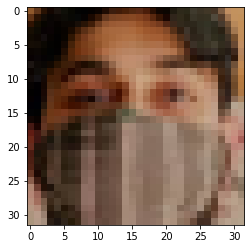

In [ ]:
img, label = test_dataset[7]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, model))

